In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as impg

%matplotlib inline

In [2]:
camera_cal_img_paths = list(map(lambda path: './camera_cal/' + path.split('\\')[-1] ,
                     glob.glob('./camera_cal/*.jpg')))
test_img_paths = list(map(lambda path: './test_images/' + path.split('\\')[-1],
                          glob.glob('./test_images/*.jpg')))

In [4]:
camera_cal_img_paths.sort(key = lambda x: 11 * len(x) + int(x[-5]))

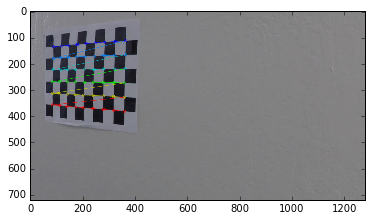

In [5]:
## CAMERA CALIBRATE
# Loop through images find the imgpoints
nx = 9
ny = 6
objp = np.zeros((ny * nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

objpoints = []
imgpoints = []
for img_path in camera_cal_img_paths:
    img = plt.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
        objpoints.append(objp)
        imgpoints.append(corners)


In [6]:
# camera calibration
ret, mtx, dist, rvess, tvess = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


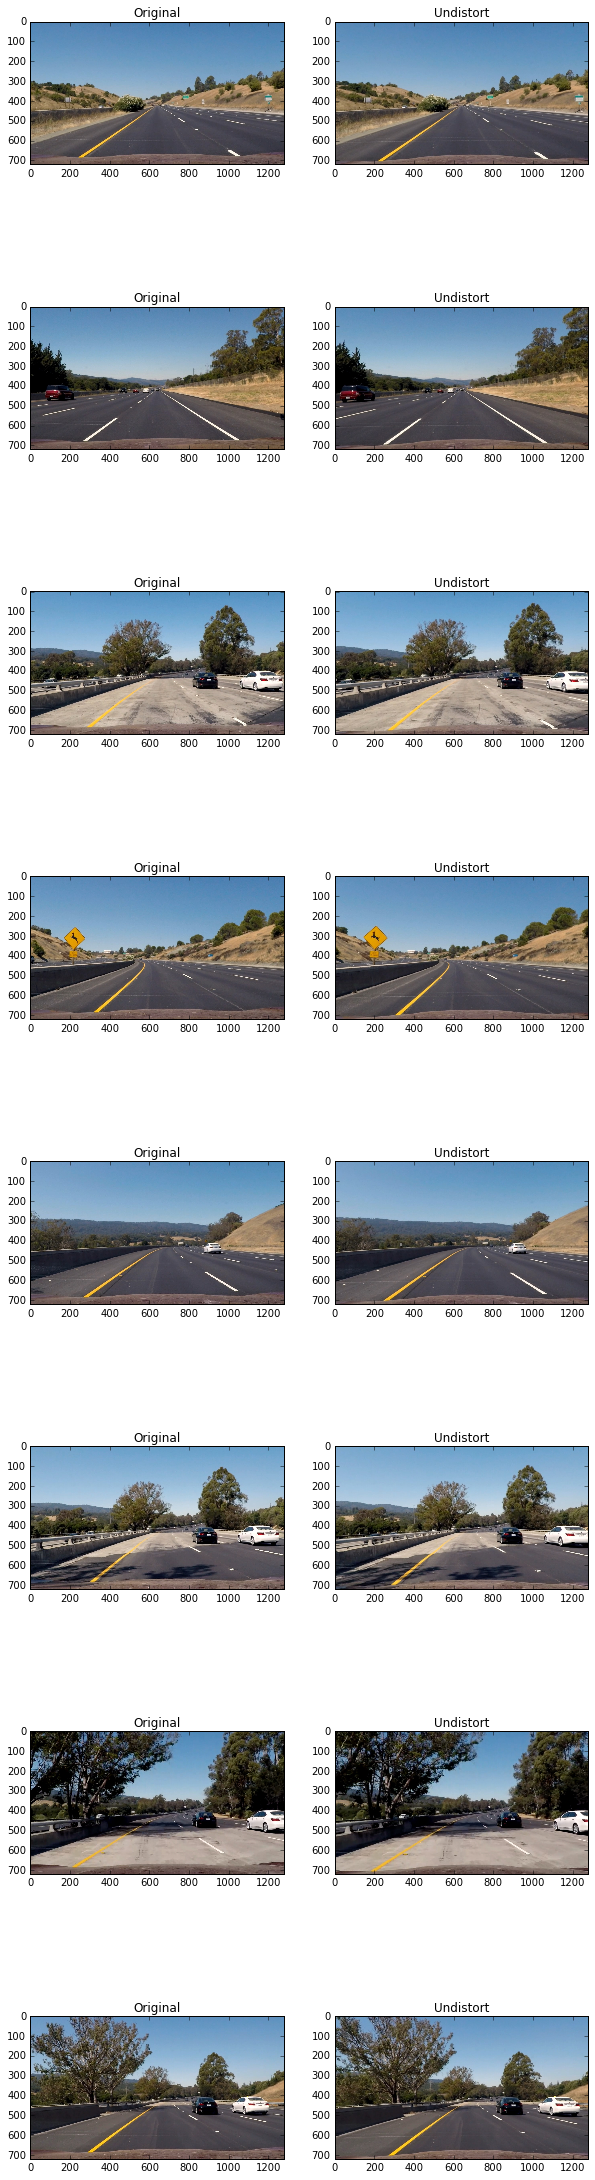

In [7]:
fig, axes = plt.subplots(8, 2, figsize=(10, 40))
undist_imgs = []
for i, img_path in enumerate(test_img_paths):
    img = plt.imread(img_path)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_imgs.append(undist)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Original')
    axes[i, 1].imshow(undist)
    axes[i, 1].set_title('Undistort')

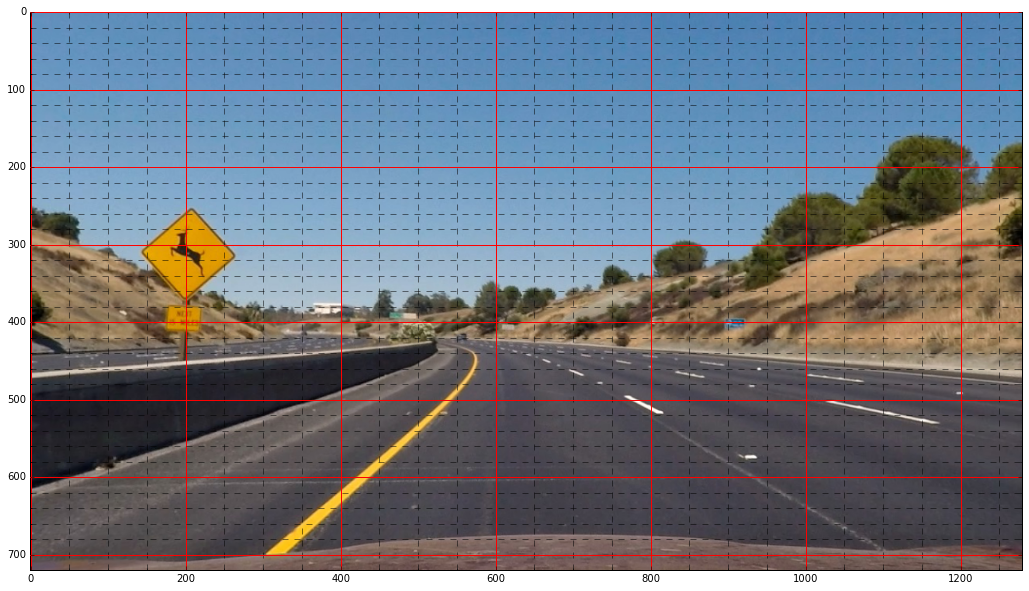

In [8]:
## PERSPECTIVE TRANSFORM

img = undist_imgs[3]

plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(img)
plt.minorticks_on()
plt.grid(which = 'minor', color = 'black', linestyle='--', linewidth=0.5)
plt.grid( color = 'red', linestyle='-', linewidth=1)

In [9]:
src = np.float32([[570, 467],
                  [206, 720], 
                  [715, 467],
                  [1100, 720]])
dest = np.float32([[320, 200],
                   [320, 720],
                   [968, 200],
                   [968, 720]])

In [10]:
M = cv2.getPerspectiveTransform(src, dest)
M_inv = cv2.getPerspectiveTransform(dest, src)
wraped = cv2.warpPerspective(img, M, img.shape[1::-1], flags = cv2.INTER_LINEAR)

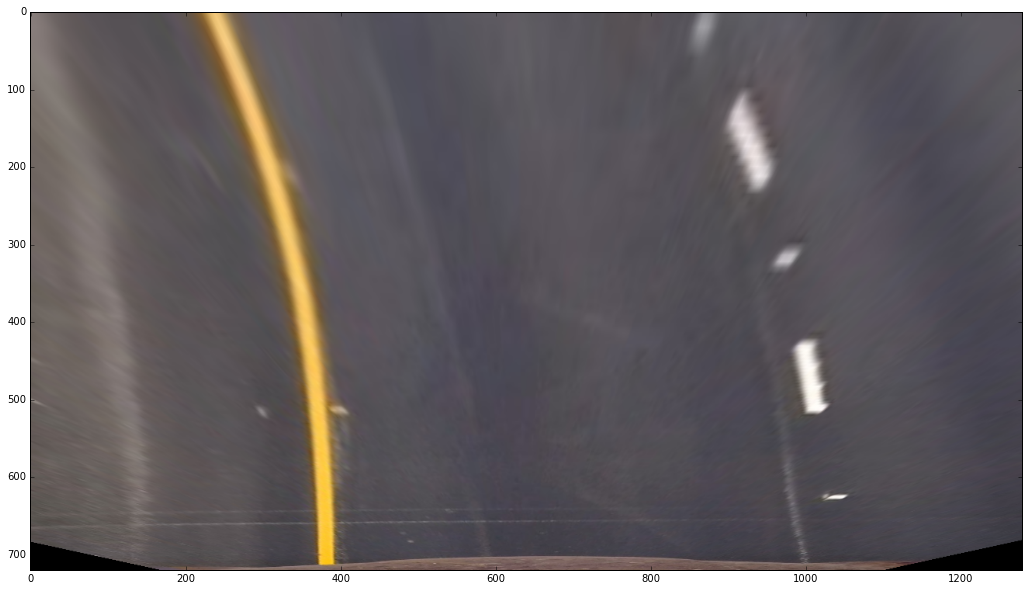

In [11]:
plt.imshow(wraped)

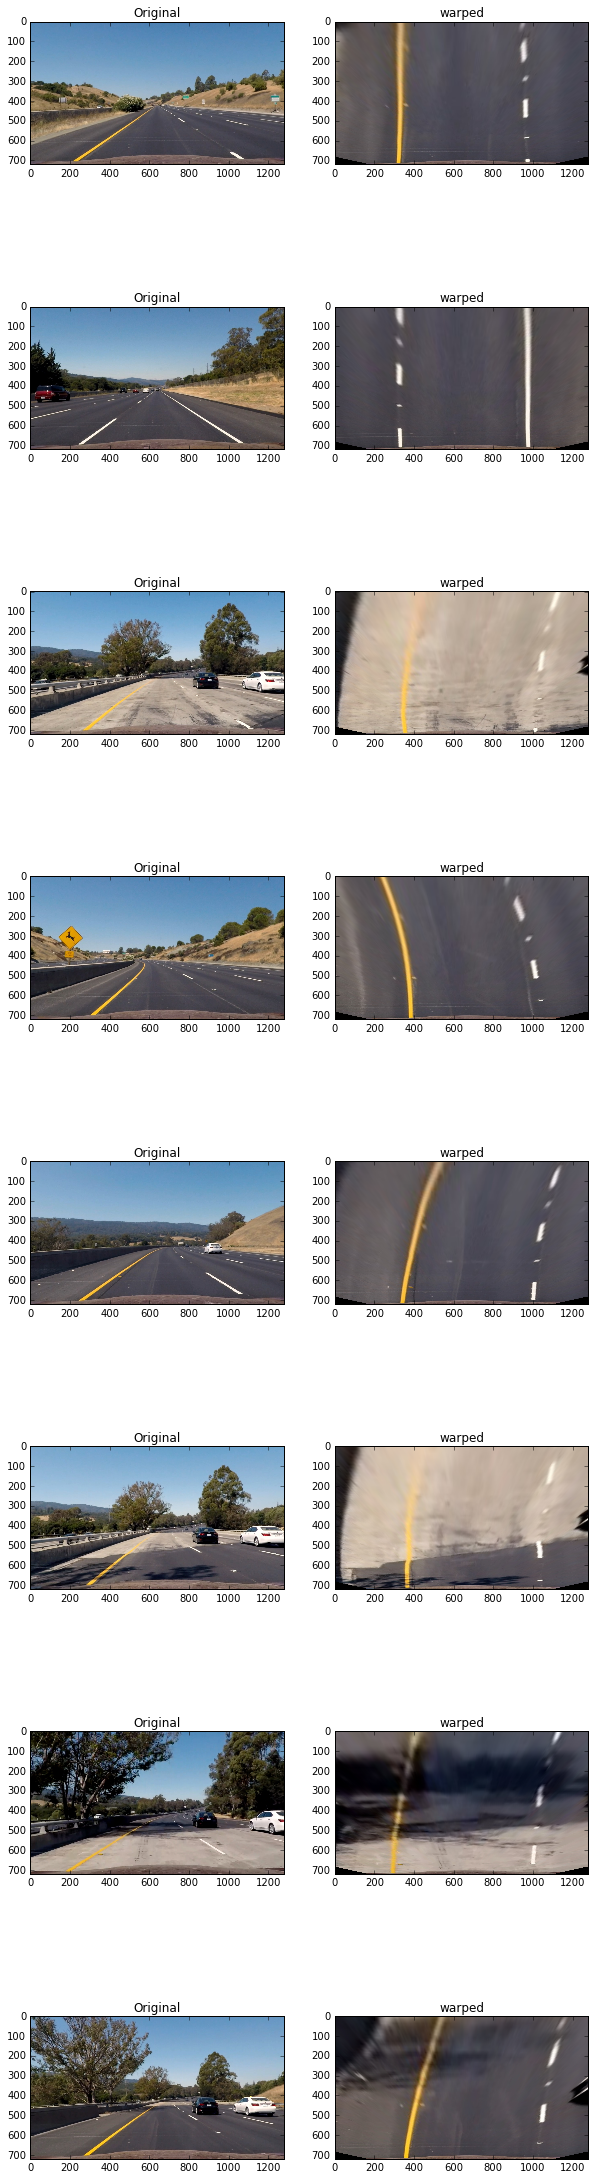

In [12]:
fig, axes = plt.subplots(8, 2, figsize=(10, 40))
warpeds = []
for i, img in enumerate(undist_imgs):
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags = cv2.INTER_LINEAR)
    warpeds.append(warped)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Original')
    axes[i, 1].imshow(warped)
    axes[i, 1].set_title('warped')

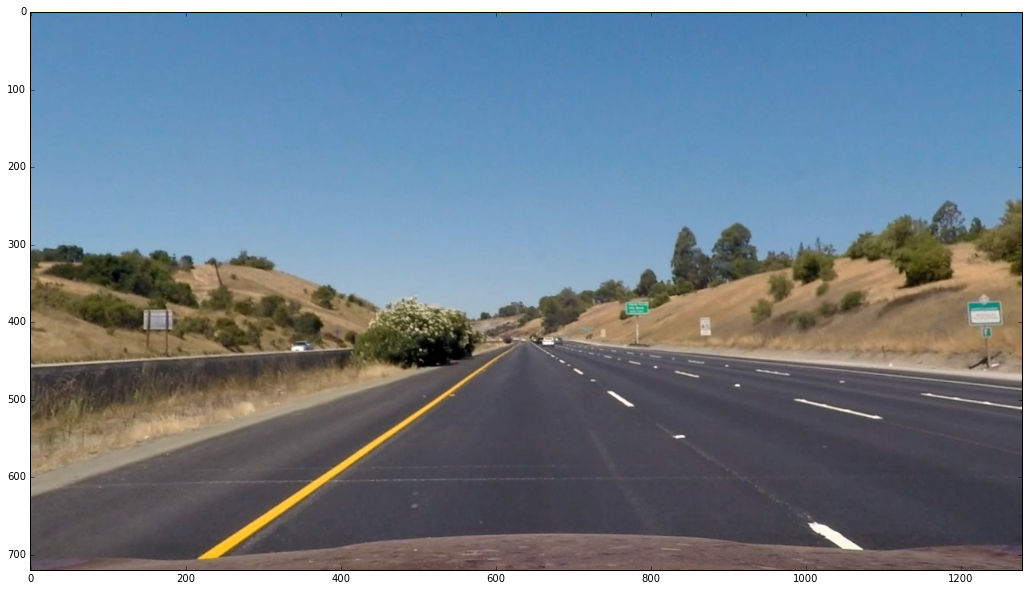

In [140]:
## THRESHOLDING

img = undist_imgs[0]
plt.imshow(img)

In [141]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
l_channel = hls[:, :, 1]
s_channel = hls[:, :, 2]

In [142]:
sx_thres = [20, 100]
s_thres = [120, 255]

In [143]:
sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
abs_sobelx = np.absolute(sobelx)
scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
sxbinary = np.zeros_like(l_channel)
sxbinary[(scaled_sobel >= sx_thres[0]) & (scaled_sobel < sx_thres[1])] = 1

In [144]:
s_binary = np.zeros_like(l_channel)
s_binary[(s_channel >= s_thres[0]) & (s_channel < s_thres[1])] = 1

In [145]:
combined_binary = np.zeros_like(l_channel)
combined_binary[(sxbinary == 1) | (s_binary == 1)] = 1

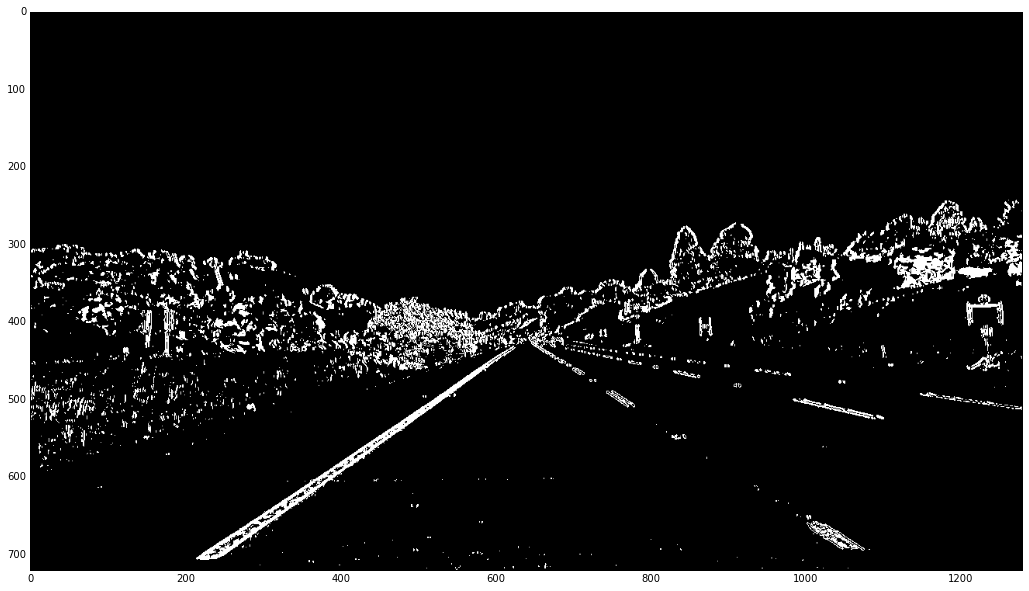

In [146]:
plt.imshow(combined_binary, cmap = 'gray')

In [147]:
warped = cv2.warpPerspective(combined_binary, M, img.shape[1::-1], flags = cv2.INTER_LINEAR)

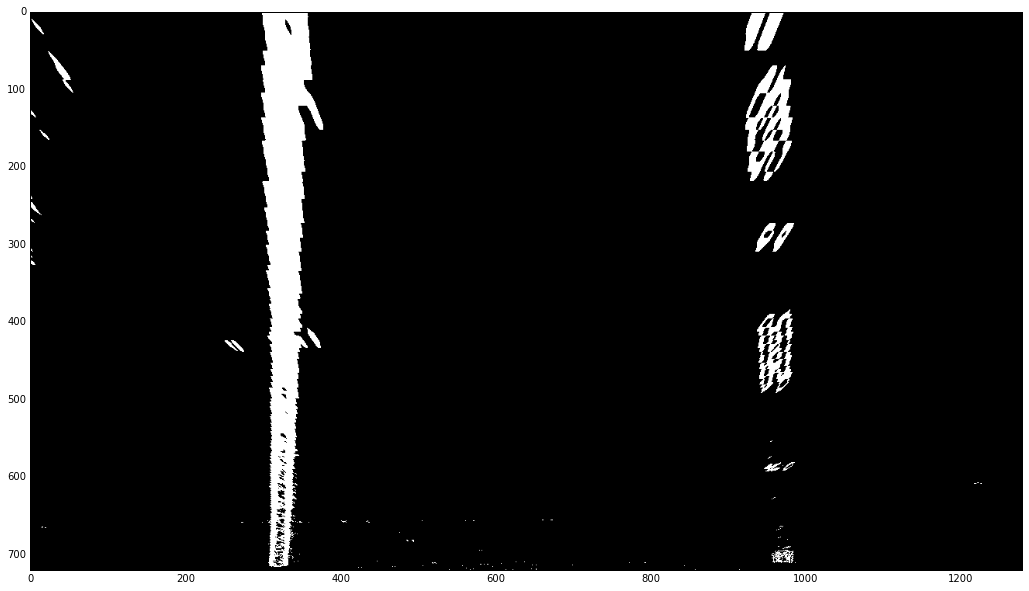

In [148]:
plt.imshow(warped, cmap = 'gray')

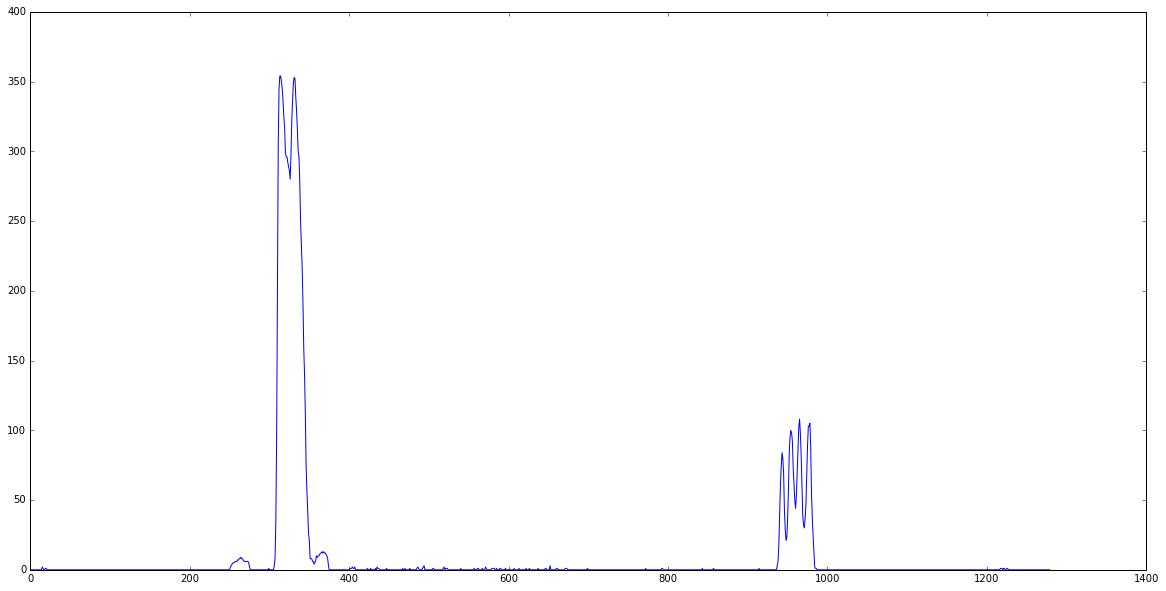

In [149]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
binary_warped = warped

In [150]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 75
# Set minimum number of pixels found to recenter window
minpix = 100
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

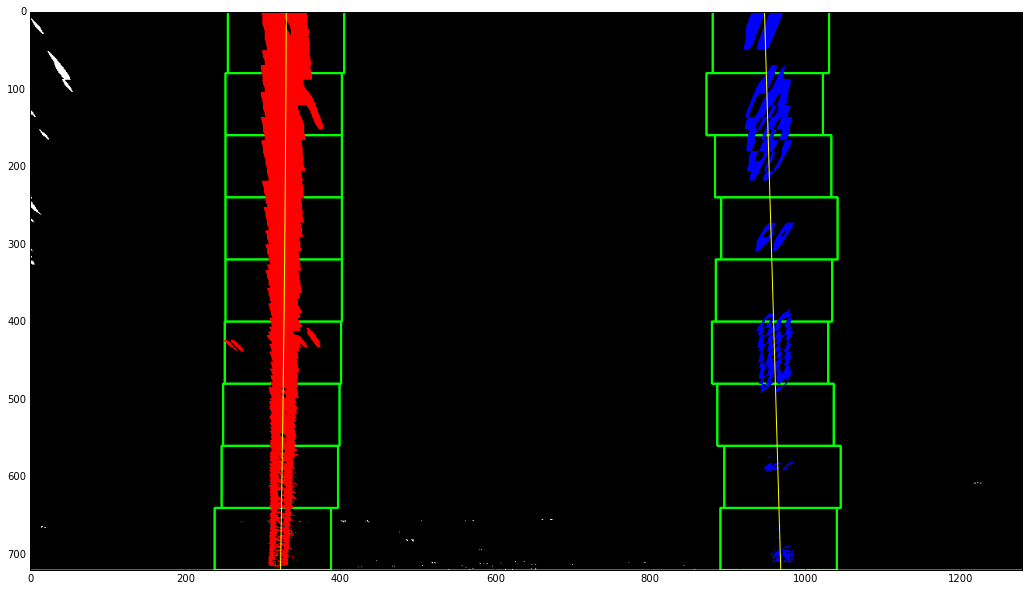

In [151]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [152]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 75
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

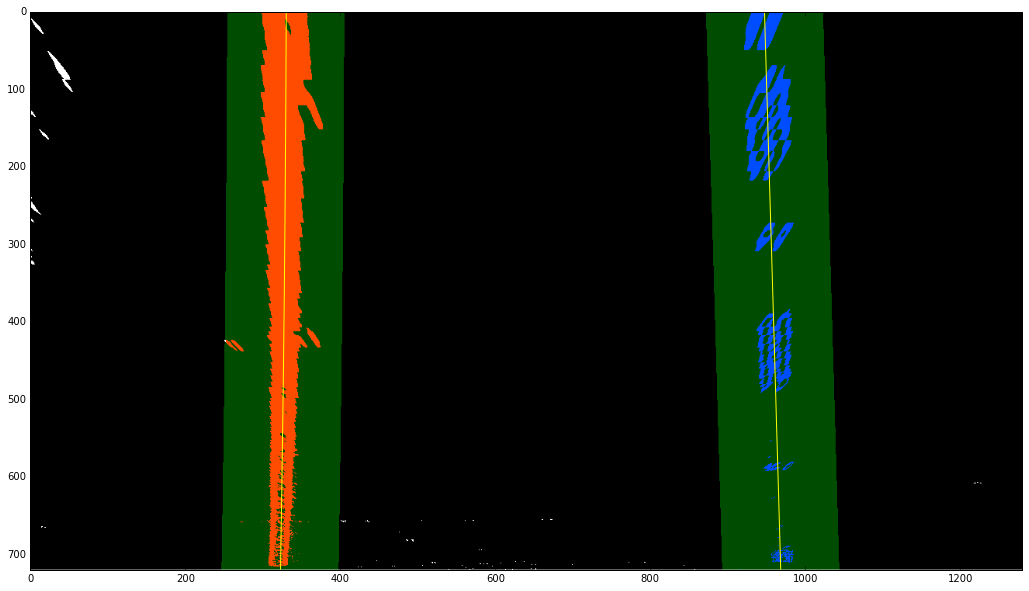

In [153]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

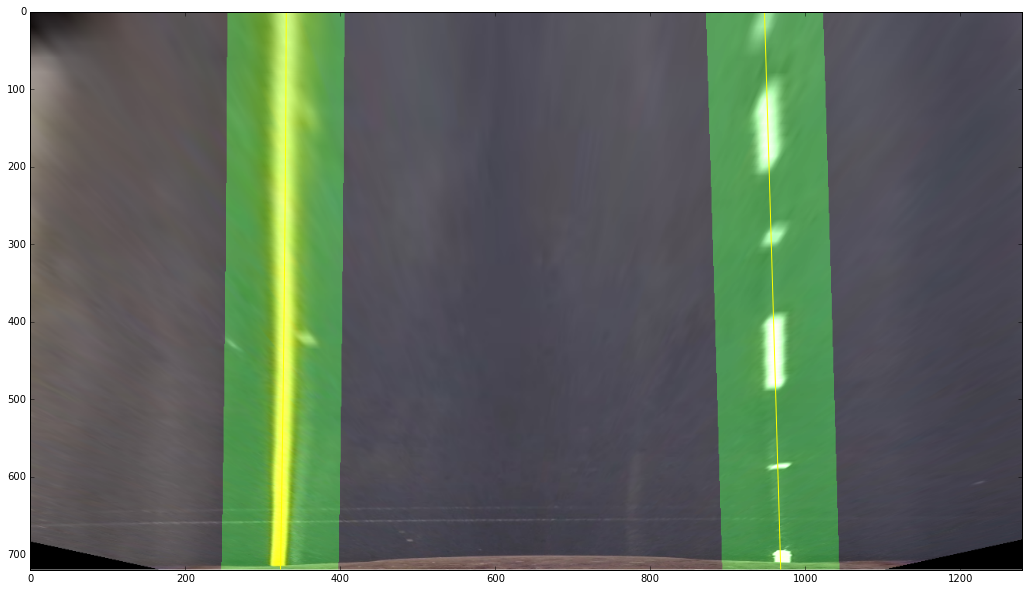

In [154]:
# Create an image to draw on and an image to show the selection window
out_img = cv2.warpPerspective(img, M, img.shape[1::-1], flags = cv2.INTER_LINEAR)
window_img = np.zeros_like(out_img)

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

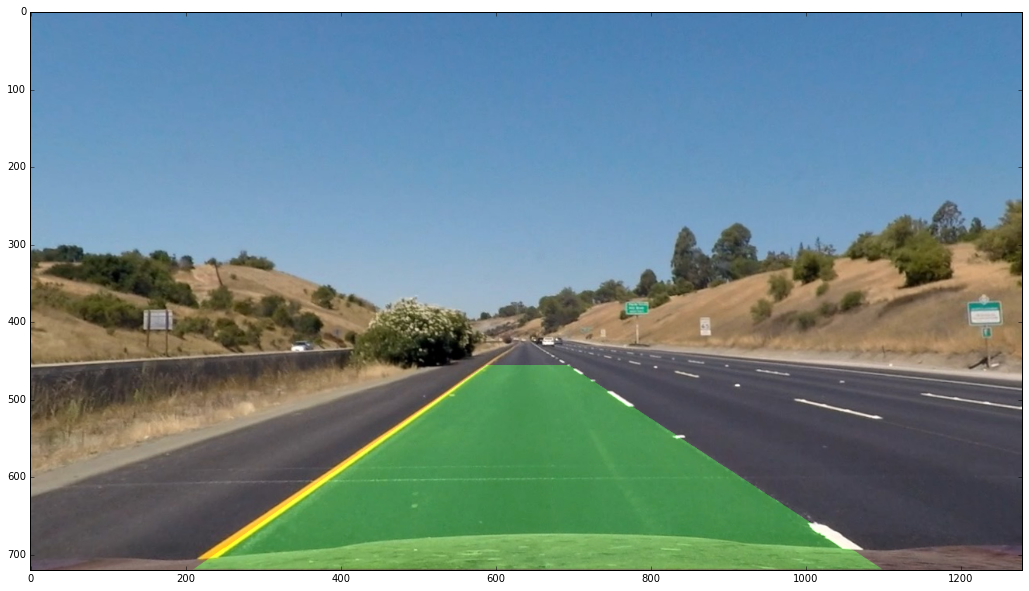

In [155]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [156]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

53069.345445893785 523233.5986697199


In [157]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/800 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

19912.32402711989 m 196173.950165514 m


In [158]:
lane_center = (right_fit_cr[2] - left_fit_cr[2]) / 2 + left_fit_cr[2] 

In [159]:
vehicle_center = (1280 * 3.7 / 800) / 2

In [160]:
vehicle_center - lane_center

0.005690802710812015

In [161]:
text1 = 'Left curverad: {0:.0f}(m), Right curverad: {1:.0f}(m)'.format(
    left_curverad, right_curverad)
text2 = 'Vehicle is meter left to the center'


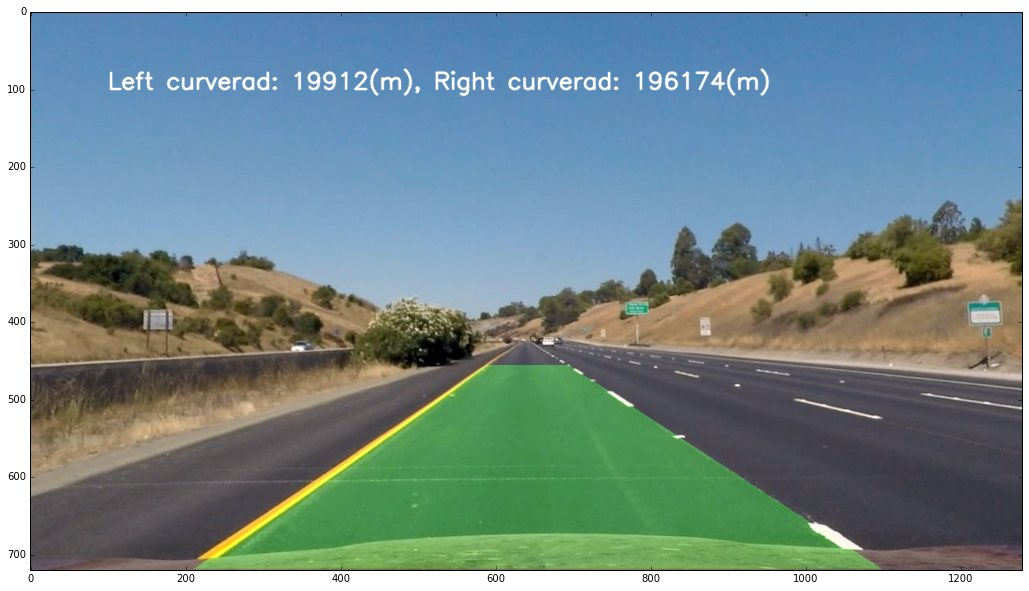

In [162]:
result_wtext = result.copy()
font = cv2.FONT_HERSHEY_SIMPLEX
plt.imshow(cv2.putText(result_wtext,text1,(100,100), font, 1,(255,255,255),2,cv2.LINE_AA))

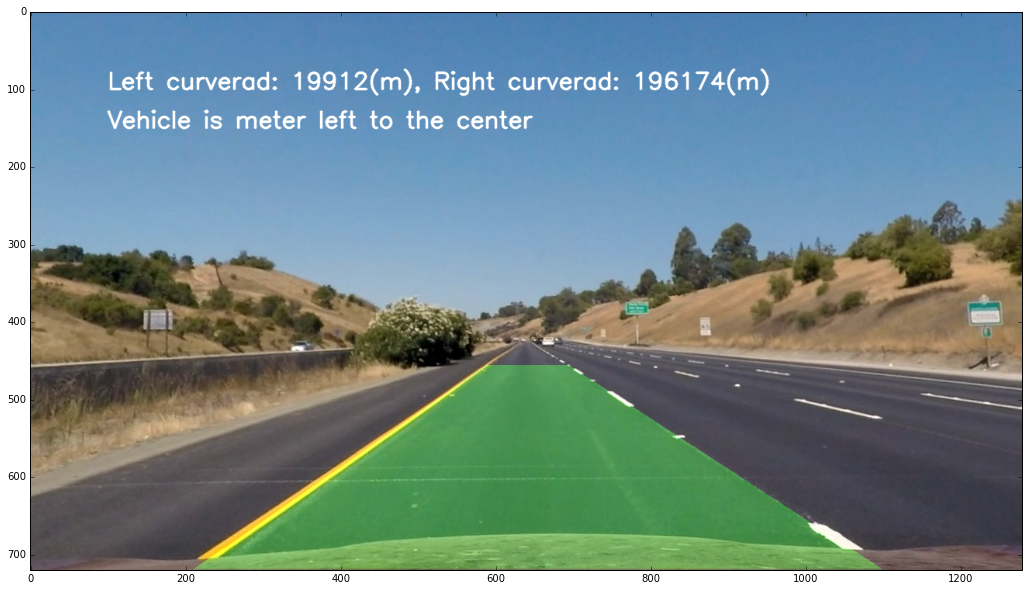

In [163]:
plt.imshow(cv2.putText(result_wtext,text2,(100,150), font, 1,(255,255,255),2,cv2.LINE_AA))

In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [4]:
clip1 = VideoFileClip("./challenge_video.mp4").subclip(0,10)